# Wind Loading Analysis for the EB Ground Station

## Intro

### Resources
* [Average daily wind data for Portland][AWND]
* Free historical weather data on [Wunderground]. 
    * Note: It only displays the data one year at a time, at most... Anyone want to write a little scraping script?
* [NOAA report][2007 report] on the 2007 storm. (Costal data)
* There's this [city-data thread] where someone claims that 116 mph winds were observed on the Morrison bridge during the Columbus Day storm. Sadly, they do not cite any sources...

[AWND]: http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.DAILY/.FSOD/WBAN+24229+VALUE/.AWND/
[Wunderground]: https://www.wunderground.com/history/airport/KPDX/
[2007 report]: http://www.wrh.noaa.gov/pqr/paststorms/20071203/tabular_obs.php#winds
[city-data thread]: http://www.city-data.com/forum/weather/621044-what-highest-winds-ever-recorded-your-2.html

### TODO
* get the missing parameters
    * get the drag coefficient for the antenna/station (with ice)
        * you can estimate this if you know the dimensions of the antenna. Just model it as a whole bunch of cylinders. The Cd of a cylinder is well known.
        * Slight annoyance: C_d is a function of Re. The smallest conductors on the antenna will have a different Re than the mast, for example. Buuuuut, a factor of 2 or 3 change in Re usually corresponds to a very small change in C_d. (should be confirmed)
    * get the maximum expected wind speed
    * get the frontal area for the antenna, with ice
        * It would also be neat if we could calculate the corresponding ice thickness.
    * get an acceptable factor of safety on the wind speed
    * get the actual value for the center of mass 
        * get the mass of the blocks
        * get the mass of the tubes
        * get the mass of the antenna/equipment (with ice)
* put things in terms of initial parameters
    * CoP in terms of the station dimensions
    * wind loading in terms of speed and Cd
* make a non-shitty version of the loading diagram

### Problem Description

#### Failure Mode: Tipping
We want to know how heavy the feet of the ground station need to be in order to **keep it from tipping over in high winds.**  
We are assuming the worst-case is that antenna will be covered in ice during a wind storm. The criterion for tipping is when the moment due to wind is equal and opposite to the moment due to gravity. 

I'm choosing the foot weight as the "trim" variable, since it's a lot easier to just swap out some larger blocks than to find out, say, that we need to redesign the ground station for a larger mast diameter.

#### Failure Mode: Bending
We also want to know the necessary size and material of the mast, so that it **doesn't bend.**  
Stress analysis will be done in SolidWorks.

### Solution
#### Design Process 
1. choose arbitrary dimensions for the ground station
2. find the worst-case loading
3. determine if any part of the ground station will yield
    * If it does, go to 1.
4. determine if the ground station will tip over
    * If it will, add weight to the feet.

#### Information I/O:
* Empirical C_d data: (profile of antenna conductors, typical conductor diameter, ripped plots from Munson book, wind speed) -> approximate C_d for the whole antenna (probably about 1.2) 
* Drag equation: (wind speed, air density, C_d, frontal area) -> drag on antenna
* (same collection of variables as above) -> drag on mast, legs
* (leg dimensions, material) -> leg CoM
* 2nd law for moments: (CoMs of all components, masses of all components, drag on antenna) -> necessary foot mass to prevent tipping

### Setup

#### Imports

In [30]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import magnitude as mag
from magnitude import mg
mag.new_mag('lbm', mag.Magnitude(0.45359237, kg=1))
mag.new_mag('lbf', mg(4.4482216152605, 'N'))
mag.new_mag('mph', mg(0.44704, 'm/s'))
from IPython.display import display, Markdown, Latex
def printBig(*message): # like print(), but with header2 formatting
    display(Markdown( '## ' + ' '.join([str(x) for x in message]) ))
print(sys.version)
%matplotlib inline

3.4.3 (default, Nov 17 2016, 01:08:31) 
[GCC 4.8.4]


![](loadingDiagram.png)

## maximum **_average_** daily wind speed in PDX:  34.1 mph

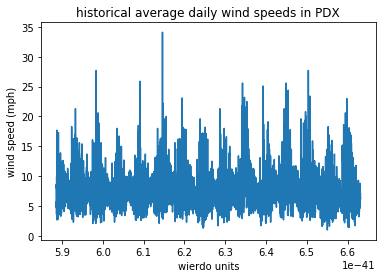

In [31]:
df_wind= pd.read_csv('NOAA_NCDC_DAILY_FSOD_AWND_averageDailyWindSpeedData_gridtable.tsv', header=1, sep='\t')
plt.plot(df_wind['julian_day'], df_wind['mph'])
plt.title('historical average daily wind speeds in PDX')
plt.ylabel('wind speed (mph)')
plt.xlabel('wierdo units')
printBig('maximum **_average_** daily wind speed in PDX: ', round(df_wind['mph'].max(),4), 'mph')

#### input parameters

In [32]:
#### physical quantities ####
g= mg(9.81,'m/s2')                  # gravitational acceleration
rho_air= mg(1.225,'kg/m3')          # density of air at 0 C
mu_air= mg(1.7e-5,'Pa s')           # dynamic viscosity of air at 0 C
nu_air= mu_air/rho_air              # kinematic viscosity of air at 0 C
rho_steel= mg(7.8e3,'kg/m3')        # density of steel
rho_al= mg(2.7e3,'kg/m3')           # density of aluminum
rho_fg= mg(1520,'kg/m3')            # density of fiberglass

#### ground station parameters ####
Cd= mg(1.2)                         # Drag coefficient of a cylinder/antenna at relevant speeds, (THIS IS A GUESS)
Fg= mg(300,'lbf')                   # weight of the ground station (THIS IS A GUESS)
v_wind= mg(100,'mph')               # max expexted wind speed (WHAT'S THE JUSTIFICATION HERE?)
# legs
Lxy_leg= mg(77,'inch')              # length of a leg projected in the XY plane
L_leg= mg(78.75,'inch')             # length of a leg
L_truss= mg(48.75,'inch')           # length of the beam fixing a leg
# antennas
A_70cm= mg(4.0,'ft2')               # frontal area of the 70 cm antenna
A_2m= mg(5.0,'ft2')                 # frontal area of the 2 m antenna
# mast
L_mast= mg(180,'inch')              # length of the mast
OD_mast= mg(1.9,'inch')             # outer diameter of the mast
ID_mast= mg(1.48,'inch')            # inner diameter of the mast
# cross boom
OD_crossBoom= mg(2.0,'inch')        # outer diameter of the cross boom
ID_crossBoom= mg(1.5,'inch')        # inner diameter of the cross boom
L_crossBoom= mg(60+60+10.75,'inch') # length of the cross boom
rho_crossBoom= rho_fg               # density of the cross boom
# legs
OD_leg= mg(1.0,'inch')              # outer diameter of the legs
ID_leg= OD_leg-mg(2*0.2,'inch')     # inner diameter of the legs (GUESSING A 0.2" wall)

# geometry
Lx_leg= Lxy_leg*mg(np.cos(np.pi/3)) # length of a leg projected in the X axis
A_total= A_70cm+A_2m

## Calculations

In [33]:
D_wind= mg(1/2)*rho_air*A_total*Cd*v_wind**2
print(D_wind.ounit('N'))

1228.1532 N


$
My_{tip} = 0\\
0 = Fx_{windCR}*Hz_{CoP} - Fg*Lx_{leg} \\
Fx_{windCR} = \frac{Fg*Lx_{leg}}{Hz_{CoP}}
$

In [34]:
Fx_windCR= Fg*Lx_leg/Hz_CoP
printBig('critical wind force:', round(Fx_windCR,4) , '')

NameError: name 'Hz_CoP' is not defined